# .............................................................................................:::::MLP:::::......................................................................................................................................

## .::Preprocesamiento para MLP :::......................................................................................................................................

In [46]:
import os
import cv2
import numpy as np
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage import feature
from scipy import stats
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

In [47]:
print("\nROI definido:")
roi_crop = {
    'x1_pct': 0.05,
    'y1_pct': 0.05,
    'x2_pct': 0.95,
    'y2_pct': 0.95,
}

area_conservada = ((roi_crop['x2_pct'] - roi_crop['x1_pct']) * 
                    (roi_crop['y2_pct'] - roi_crop['y1_pct']))

print(f"   ROI: X[{roi_crop['x1_pct']:.1%} - {roi_crop['x2_pct']:.1%}], "
        f"Y[{roi_crop['y1_pct']:.1%} - {roi_crop['y2_pct']:.1%}]")
print(f"   Área conservada: {area_conservada:.2%}")


ROI definido:
   ROI: X[5.0% - 95.0%], Y[5.0% - 95.0%]
   Área conservada: 81.00%


In [48]:
def visualize_roi(input_path, roi_crop, n_examples=9, save_path='roi_visualization.png'):
    """Visualiza el ROI en ejemplos aleatorios"""
    img_files = list(Path(input_path).rglob('*.png'))
    samples = np.random.choice(img_files, min(n_examples, len(img_files)), replace=False)
    
    rows = 2
    cols = n_examples
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5))
    
    for idx, img_path in enumerate(samples):
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        x1 = int(roi_crop['x1_pct'] * w)
        y1 = int(roi_crop['y1_pct'] * h)
        x2 = int(roi_crop['x2_pct'] * w)
        y2 = int(roi_crop['y2_pct'] * h)
        
        img_with_roi = img_rgb.copy()
        cv2.rectangle(img_with_roi, (x1, y1), (x2, y2), (255, 0, 0), 2)
        
        img_cropped = img_rgb[y1:y2, x1:x2]
        
        axes[0, idx].imshow(img_with_roi)
        axes[0, idx].set_title(f'Original\n{w}×{h}', fontsize=8)
        axes[0, idx].axis('off')
        
        axes[1, idx].imshow(img_cropped)
        axes[1, idx].set_title(f'Recortada\n{x2-x1}×{y2-y1}', fontsize=8)
        axes[1, idx].axis('off')
    
    plt.suptitle('Visualización del ROI Propuesto', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

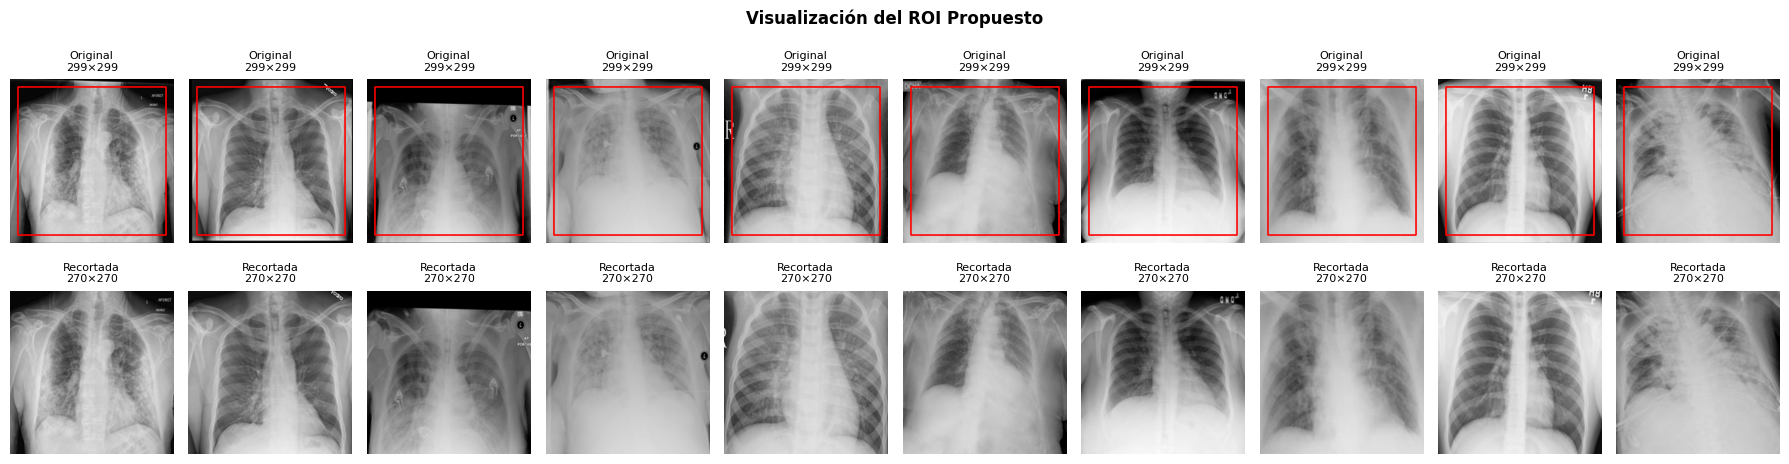

In [49]:
visualize_roi('COVID-19_Radiography_Dataset', roi_crop, n_examples=10)

In [50]:
def preprocess_image(img, roi_crop, target_size=(128, 128)):
    """
    Pipeline: ROI → Grayscale → CLAHE → Denoise → Resize
    """
    h, w = img.shape[:2]
    
    # 1. Recortar ROI
    x1 = int(roi_crop['x1_pct'] * w)
    y1 = int(roi_crop['y1_pct'] * h)
    x2 = int(roi_crop['x2_pct'] * w)
    y2 = int(roi_crop['y2_pct'] * h)
    
    img_cropped = img[y1:y2, x1:x2]
    
    # 2. Convertir a grayscale
    gray = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
    
    # 3. Aplica CLAHE 
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(gray)
    
    # 4. Gaussian blur suave para reducir ruido
    img_smooth = cv2.GaussianBlur(img_clahe, (3, 3), 0)
    
    # 5. Redimensionar
    img_resized = cv2.resize(img_smooth, target_size, interpolation=cv2.INTER_AREA)
    
    return img_resized

In [51]:
def process_single_image(args):
    """Worker function para procesamiento paralelo"""
    input_path, output_path, roi_crop, target_size = args
    
    try:
        img = cv2.imread(input_path)
        if img is None:
            return False, "No se pudo leer"
        
        img_processed = preprocess_image(img, roi_crop, target_size)
        
        # Guardar con compresión
        cv2.imwrite(output_path, img_processed, [cv2.IMWRITE_PNG_COMPRESSION, 9])
        return True, None
        
    except Exception as e:
        return False, str(e)

In [52]:
def visualize_preprocessing_steps(dataset_path, roi_crop, target_size=(128, 128), n_examples=5):
    # Buscar imágenes de ejemplo
    img_files = list(Path(dataset_path).rglob('*.png'))
    samples = np.random.choice(img_files, min(n_examples, len(img_files)), replace=False)
    
    # Crear figura
    fig, axes = plt.subplots(n_examples, 6, figsize=(18, 3*n_examples))
    
    if n_examples == 1:
        axes = axes.reshape(1, -1)
    
    titles = ['1. Original', '2. ROI Crop', '3. Grayscale', '4. CLAHE', '5. Blur', '6. Resized']
    
    for idx, img_path in enumerate(samples):
        img = cv2.imread(str(img_path))
        if img is None:
            continue
        
        h, w = img.shape[:2]
        
        # Paso 0: Original
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[idx, 0].imshow(img_rgb)
        axes[idx, 0].axis('off')
        if idx == 0:
            axes[idx, 0].set_title(titles[0], fontweight='bold')
        
        # Paso 1: ROI Crop
        x1 = int(roi_crop['x1_pct'] * w)
        y1 = int(roi_crop['y1_pct'] * h)
        x2 = int(roi_crop['x2_pct'] * w)
        y2 = int(roi_crop['y2_pct'] * h)
        img_cropped = img[y1:y2, x1:x2]
        img_cropped_rgb = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2RGB)
        axes[idx, 1].imshow(img_cropped_rgb)
        axes[idx, 1].axis('off')
        if idx == 0:
            axes[idx, 1].set_title(titles[1], fontweight='bold')
        
        # Paso 2: Grayscale
        gray = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
        axes[idx, 2].imshow(gray, cmap='gray')
        axes[idx, 2].axis('off')
        if idx == 0:
            axes[idx, 2].set_title(titles[2], fontweight='bold')
        
        # Paso 3: CLAHE
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        img_clahe = clahe.apply(gray)
        axes[idx, 3].imshow(img_clahe, cmap='gray')
        axes[idx, 3].axis('off')
        if idx == 0:
            axes[idx, 3].set_title(titles[3], fontweight='bold')
        
        # Paso 4: Blur
        img_smooth = cv2.GaussianBlur(img_clahe, (3, 3), 0)
        axes[idx, 4].imshow(img_smooth, cmap='gray')
        axes[idx, 4].axis('off')
        if idx == 0:
            axes[idx, 4].set_title(titles[4], fontweight='bold')
        
        # Paso 5: Resized
        img_resized = cv2.resize(img_smooth, target_size, interpolation=cv2.INTER_AREA)
        axes[idx, 5].imshow(img_resized, cmap='gray')
        axes[idx, 5].axis('off')
        if idx == 0:
            axes[idx, 5].set_title(titles[5], fontweight='bold')
        
        # Etiqueta de ejemplo
        axes[idx, 0].text(-0.1, 0.5, f'Ejemplo {idx+1}', 
                         transform=axes[idx, 0].transAxes,
                         fontsize=10, fontweight='bold',
                         va='center', ha='right', rotation=90)
    
    plt.suptitle('Pipeline de Preprocesamiento - Visualización', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [53]:
def preprocess_dataset(input_path, output_path, roi_crop, target_size=(128, 128), n_workers=None):
    """Preprocesa todo el dataset"""
    Path(output_path).mkdir(parents=True, exist_ok=True)
    
    img_files = list(Path(input_path).rglob('*.png'))
    
    print(f"\nPreprocesando {len(img_files)} imágenes")
    print(f"   ROI: X[{roi_crop['x1_pct']:.1%} - {roi_crop['x2_pct']:.1%}], "
          f"Y[{roi_crop['y1_pct']:.1%} - {roi_crop['y2_pct']:.1%}]")
    print(f"   Target size: {target_size}")
    
    args_list = []
    for img_path in img_files:
        relative_path = img_path.relative_to(input_path)
        output_file = Path(output_path) / relative_path
        output_file.parent.mkdir(parents=True, exist_ok=True)
        
        args_list.append((
            str(img_path),
            str(output_file),
            roi_crop,
            target_size
        ))
    
    if n_workers is None:
        n_workers = min(32, os.cpu_count() * 4)
    
    success_count = 0
    error_count = 0
    
    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        results = list(tqdm(
            executor.map(process_single_image, args_list),
            total=len(args_list),
            desc="Procesando",
            unit="img"
        ))
    
    for success, error in results:
        if success:
            success_count += 1
        else:
            error_count += 1
    
    print(f"\nPreprocesamiento completado:")
    print(f"   Exitosas: {success_count}")
    print(f"   Errores: {error_count}\n")

In [54]:
preprocess_dataset(input_path='COVID-19_Radiography_Dataset', 
                   output_path='Imgs_preprocessed', 
                   roi_crop=roi_crop, 
                   target_size=(128, 128))


Preprocesando 21165 imágenes
   ROI: X[5.0% - 95.0%], Y[5.0% - 95.0%]
   Target size: (128, 128)


Procesando: 100%|██████████| 21165/21165 [00:12<00:00, 1756.38img/s]


Preprocesamiento completado:
   Exitosas: 21165
   Errores: 0



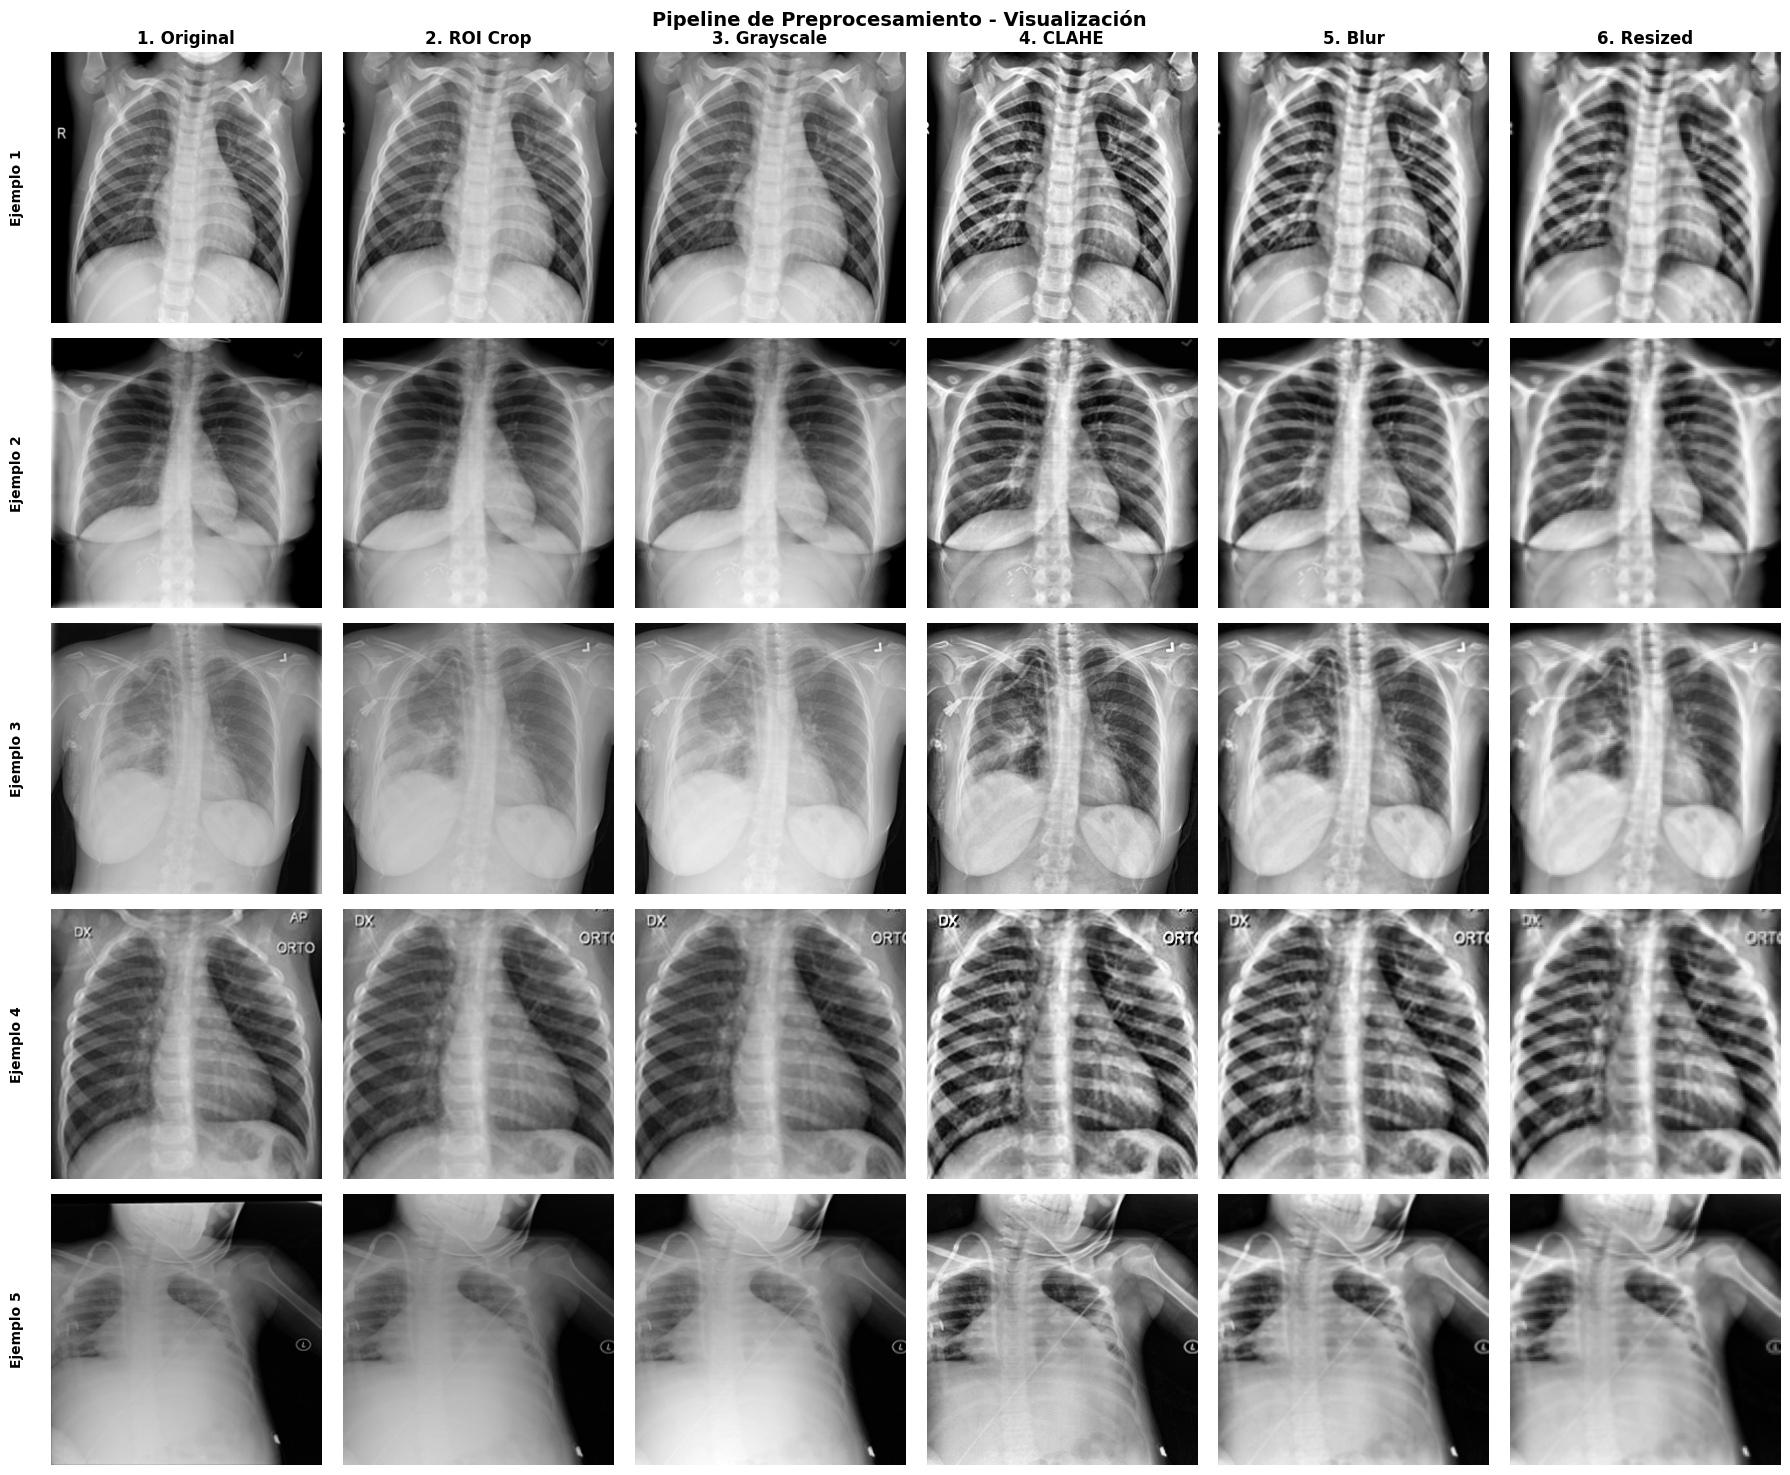

In [55]:
visualize_preprocessing_steps('COVID-19_Radiography_Dataset', roi_crop, n_examples=5)

In [56]:
def analyze_class_balance(preprocessed_path):
    """Analiza la distribución de clases"""
    class_dirs = [d for d in Path(preprocessed_path).iterdir() if d.is_dir()]
    
    class_counts = {}
    for class_dir in sorted(class_dirs):
        class_name = class_dir.name
        img_files = list(class_dir.glob('*.png'))
        count = len(img_files)
        class_counts[class_name] = count
    
    total = sum(class_counts.values())
    max_count = max(class_counts.values())
    
    print(f"\nTotal de imágenes: {total}")
    print(f"\nDistribución por clase:")
    print("-"*70)
    print(f"{'Clase':<25} {'Cantidad':<12} {'Porcentaje':<12} {'Diferencia':<12}")
    print("-"*70)
    
    for class_name, count in sorted(class_counts.items()):
        percentage = (count / total) * 100
        diff = max_count - count
        print(f"{class_name:<25} {count:<12} {percentage:<11.2f}% {diff:<12}")
    
    print("-"*70)
    
    min_count = min(class_counts.values())
    imbalance_ratio = max_count / min_count
    
    print(f"Clase más grande: {max_count} imágenes")
    print(f"Clase más pequeña: {min_count} imágenes")
    print(f"Ratio de desbalance: {imbalance_ratio:.2f}:1")
    
    if imbalance_ratio > 1.5:
        print(f"\nDESBALANCE DETECTADO (ratio > 1.5:1)")
        print(f"   Se recomienda aplicar data augmentation")
    else:
        print(f"\nDataset relativamente balanceado")
    
    return class_counts, max_count


In [57]:
class_counts, max_count = analyze_class_balance(preprocessed_path='Imgs_preprocessed')


Total de imágenes: 40768

Distribución por clase:
----------------------------------------------------------------------
Clase                     Cantidad     Porcentaje   Diferencia  
----------------------------------------------------------------------
COVID                     10192        25.00      % 0           
Lung_Opacity              10192        25.00      % 0           
Normal                    10192        25.00      % 0           
Viral Pneumonia           10192        25.00      % 0           
----------------------------------------------------------------------
Clase más grande: 10192 imágenes
Clase más pequeña: 10192 imágenes
Ratio de desbalance: 1.00:1

Dataset relativamente balanceado


In [58]:
def augment_image(img, augmentation_type):
    """Aplica transformación a una imagen"""
    h, w = img.shape[:2]
    
    if augmentation_type == 'rotate_left':
        matrix = cv2.getRotationMatrix2D((w/2, h/2), 10, 1.0)
        return cv2.warpAffine(img, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    
    elif augmentation_type == 'rotate_right':
        matrix = cv2.getRotationMatrix2D((w/2, h/2), -10, 1.0)
        return cv2.warpAffine(img, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    
    elif augmentation_type == 'flip':
        return cv2.flip(img, 1)
    
    elif augmentation_type == 'translate':
        tx = int(w * 0.05 * np.random.choice([-1, 1]))
        ty = int(h * 0.05 * np.random.choice([-1, 1]))
        matrix = np.float32([[1, 0, tx], [0, 1, ty]])
        return cv2.warpAffine(img, matrix, (w, h), borderMode=cv2.BORDER_REFLECT)
    
    elif augmentation_type == 'zoom_in':
        new_h, new_w = int(h * 1.05), int(w * 1.05)
        img_zoomed = cv2.resize(img, (new_w, new_h))
        start_y = (new_h - h) // 2
        start_x = (new_w - w) // 2
        return img_zoomed[start_y:start_y+h, start_x:start_x+w]
    
    elif augmentation_type == 'zoom_out':
        new_h, new_w = int(h * 0.95), int(w * 0.95)
        img_zoomed = cv2.resize(img, (new_w, new_h))
        top = (h - new_h) // 2
        bottom = h - new_h - top
        left = (w - new_w) // 2
        right = w - new_w - left
        return cv2.copyMakeBorder(img_zoomed, top, bottom, left, right, cv2.BORDER_REFLECT)
    
    elif augmentation_type == 'brightness_up':
        return np.clip(img * 1.1, 0, 255).astype(np.uint8)
    
    elif augmentation_type == 'brightness_down':
        return np.clip(img * 0.9, 0, 255).astype(np.uint8)
    
    return img

In [59]:
def balance_dataset(preprocessed_path, class_counts, target_count):
    """Balancea el dataset usando data augmentation"""
    augmentation_types = [
        'rotate_left', 'rotate_right', 'flip', 'translate',
        'zoom_in', 'zoom_out', 'brightness_up', 'brightness_down'
    ]
    
    total_generated = 0
    
    for class_name, current_count in class_counts.items():
        if current_count >= target_count:
            print(f"\n{class_name}: Ya tiene suficientes imágenes ({current_count})")
            continue
        
        needed = target_count - current_count
        print(f"\n{class_name}: Generando {needed} imágenes adicionales...")
        
        class_dir = Path(preprocessed_path) / class_name
        existing_files = list(class_dir.glob('*.png'))
        
        max_idx = 0
        for f in existing_files:
            try:
                idx = int(f.stem.split('-')[1])
                max_idx = max(max_idx, idx)
            except:
                continue
        
        generated = 0
        attempts = 0
        max_attempts = needed * 10
        
        with tqdm(total=needed, desc=f"  {class_name}", unit="img") as pbar:
            while generated < needed and attempts < max_attempts:
                attempts += 1
                
                source_img_path = np.random.choice(existing_files)
                img = cv2.imread(str(source_img_path), cv2.IMREAD_GRAYSCALE)
                
                if img is None:
                    continue
                
                aug_type = np.random.choice(augmentation_types)
                img_aug = augment_image(img, aug_type)
                
                new_idx = max_idx + generated + 1
                new_filename = f"{class_name}-{new_idx}.png"
                new_path = class_dir / new_filename
                
                cv2.imwrite(str(new_path), img_aug, [cv2.IMWRITE_PNG_COMPRESSION, 9])
                
                generated += 1
                total_generated += 1
                pbar.update(1)
        
        print(f"Generadas {generated} imágenes para {class_name}")
    
    print(f"\nData augmentation completado:")
    print(f"Total de imágenes generadas: {total_generated}")
    
    # Verificar nuevo balance
    print("Balance después de augmentation")

    new_class_counts = {}
    for class_name in class_counts.keys():
        class_dir = Path(preprocessed_path) / class_name
        new_count = len(list(class_dir.glob('*.png')))
        new_class_counts[class_name] = new_count
    
    total = sum(new_class_counts.values())
    print(f"\nTotal de imágenes: {total}")
    print(f"\nDistribución por clase:")
    print("-"*70)
    print(f"{'Clase':<25} {'Antes':<12} {'Después':<12} {'Incremento':<12}")
    print("-"*70)
    
    for class_name in sorted(new_class_counts.keys()):
        before = class_counts[class_name]
        after = new_class_counts[class_name]
        increment = after - before
        print(f"{class_name:<25} {before:<12} {after:<12} +{increment:<11}")
    
    return new_class_counts

In [60]:
min_count = min(class_counts.values())
imbalance_ratio = max_count / min_count

if imbalance_ratio > 1.5:
    print(f"\nBalanceando dataset\n")
    
    target_count = max_count

    print(f"Target: {target_count} imágenes por clase")
    
    class_counts = balance_dataset(preprocessed_path='Imgs_preprocessed', class_counts=class_counts, target_count=target_count)
else:
    print(f"Dataset balanceado\n")


Dataset balanceado



In [61]:
def create_raw_pixel_dataset(input_path, output_prefix='covid19_raw'):
    """
    Crea dataset con normalización Z-score
    """
    img_files = list(Path(input_path).rglob('*.png'))
    
    print(f"   Procesando {len(img_files)} imágenes...")
    
    images = []
    labels = []
    
    for img_path in tqdm(img_files, desc="Cargando imágenes"):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        
        # Normalización Z-score por imagen
        img_mean = img.mean()
        img_std = img.std()
        
        if img_std > 0:
            img_norm = (img.astype('float32') - img_mean) / img_std
        else:
            img_norm = img.astype('float32') - img_mean
        
        img_flat = img_norm.flatten()
        
        label = img_path.parent.name
        
        images.append(img_flat)
        labels.append(label)
    
    X = np.array(images, dtype='float32')
    y = np.array(labels)
    
    # Aplicar StandardScaler a nivel dataset
    print("\nAplicando StandardScaler a nivel dataset")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Guardar
    np.save(f'{output_prefix}_X.npy', X_scaled)
    np.save(f'{output_prefix}_y.npy', y)
    joblib.dump(scaler, f'{output_prefix}_scaler.pkl')
    
    print(f"\nDataset guardado:")
    print(f"   {output_prefix}_X.npy: {X_scaled.shape} ({X_scaled.nbytes/1024**2:.1f} MB)")
    print(f"   {output_prefix}_y.npy: {y.shape}")
    print(f"   {output_prefix}_scaler.pkl: Guardado")
    
    print(f"\n   Distribución de clases:")
    unique, counts = np.unique(y, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"      {label}: {count}")
    
    return X_scaled, y

In [62]:
def split_train_val_test_numpy(X, y, output_prefix, val_size=0.15, test_size=0.15, random_state=42):
    """Split train/validation/test estratificado"""
    print("SPLIT: TRAIN / VALIDATION / TEST")
    
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    val_size_adjusted = val_size / (1 - test_size)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=val_size_adjusted,
        random_state=random_state,
        stratify=y_temp
    )
    
    # Guardar
    np.save(f'{output_prefix}_X_train.npy', X_train)
    np.save(f'{output_prefix}_X_val.npy', X_val)
    np.save(f'{output_prefix}_X_test.npy', X_test)
    np.save(f'{output_prefix}_y_train.npy', y_train)
    np.save(f'{output_prefix}_y_val.npy', y_val)
    np.save(f'{output_prefix}_y_test.npy', y_test)
    
    total = len(y)
    print(f"\nSplit completado:")
    print(f"   Total: {total} muestras")
    print(f"\n   Train:      {X_train.shape} ({len(y_train):5d} = {len(y_train)/total*100:5.1f}%)")
    print(f"   Validation: {X_val.shape} ({len(y_val):5d} = {len(y_val)/total*100:5.1f}%)")
    print(f"   Test:       {X_test.shape} ({len(y_test):5d} = {len(y_test)/total*100:5.1f}%)")
    
    print(f"\n   Distribución Train:")
    unique, counts = np.unique(y_train, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"      {label:<25} {count}")
    
    print(f"\n   Distribución Validation:")
    unique, counts = np.unique(y_val, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"      {label:<25} {count}")
    
    print(f"\n   Distribución Test:")
    unique, counts = np.unique(y_test, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"      {label:<25} {count}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [63]:
val_size=0.15
test_size=0.15
random_state=42

X_raw, y_raw = create_raw_pixel_dataset(input_path='Imgs_preprocessed', output_prefix='covid19_raw')
split_train_val_test_numpy(X_raw, y_raw, 'covid19_raw', val_size, test_size, random_state)

   Procesando 40768 imágenes...


Cargando imágenes: 100%|██████████| 40768/40768 [02:09<00:00, 314.01it/s]



Aplicando StandardScaler a nivel dataset

Dataset guardado:
   covid19_raw_X.npy: (40768, 16384) (2548.0 MB)
   covid19_raw_y.npy: (40768,)
   covid19_raw_scaler.pkl: Guardado

   Distribución de clases:
      COVID: 10192
      Lung_Opacity: 10192
      Normal: 10192
      Viral Pneumonia: 10192
SPLIT: TRAIN / VALIDATION / TEST

Split completado:
   Total: 40768 muestras

   Train:      (28536, 16384) (28536 =  70.0%)
   Validation: (6116, 16384) ( 6116 =  15.0%)
   Test:       (6116, 16384) ( 6116 =  15.0%)

   Distribución Train:
      COVID                     7134
      Lung_Opacity              7134
      Normal                    7134
      Viral Pneumonia           7134

   Distribución Validation:
      COVID                     1529
      Lung_Opacity              1529
      Normal                    1529
      Viral Pneumonia           1529

   Distribución Test:
      COVID                     1529
      Lung_Opacity              1529
      Normal                    1529
 

(array([[-1.1301343e-01, -6.5940060e-02,  7.9988047e-02, ...,
         -1.2651193e+00, -1.1584160e+00, -1.0568243e+00],
        [-3.0650428e-01, -2.3403157e-01, -2.6217112e-01, ...,
          1.0004444e+00,  1.1233110e+00,  1.2552387e+00],
        [ 1.4371814e+00,  1.4287852e+00,  1.5829809e+00, ...,
          3.7612957e-01,  3.5402466e-02, -2.9284239e-01],
        ...,
        [ 2.8605850e+00,  1.5298225e+00,  1.0848457e+00, ...,
         -1.9597012e-01, -7.2299950e-02,  1.6436041e-03],
        [-6.0270035e-01, -6.2887299e-01, -6.5889233e-01, ...,
         -1.0777477e+00, -9.7345954e-01, -8.2069141e-01],
        [ 2.7528725e+00,  1.6573607e+00,  7.8914005e-01, ...,
          1.0711055e-01, -2.1890262e-01, -3.5901567e-01]],
       shape=(28536, 16384), dtype=float32),
 array([[ 1.8789659 ,  1.7122259 ,  1.5100157 , ...,  1.5307826 ,
          1.6397456 ,  1.6701071 ],
        [ 0.43019354,  0.6947    ,  0.6876302 , ...,  0.9337595 ,
          1.0590684 ,  1.1042118 ],
        [ 0.42156

In [64]:
class MultiScaleLBP:
    """
    Extractor de features LBP 
    """
    def __init__(self):
        self.configs = [
            {'radius': 1, 'points': 8},   # Patrones finos
            {'radius': 3, 'points': 16},  # Patrones medios
            {'radius': 5, 'points': 24},  # Patrones gruesos
        ]
    
    def describe(self, image):
        """
        Extrae features multi-escala
        
        Returns:
            Array con todos los features concatenados
        """
        features = []
        
        # LBP en múltiples escalas
        for config in self.configs:
            lbp = feature.local_binary_pattern(
                image, 
                config['points'],
                config['radius'], 
                method="uniform"
            )
            
            # Histograma normalizado
            hist, _ = np.histogram(
                lbp.ravel(),
                bins=np.arange(0, config['points'] + 3),
                range=(0, config['points'] + 2),
                density=True
            )
            
            features.extend(hist.tolist())
        
        # Features estadísticas adicionales
        features.extend([
            image.mean(),                  # Media
            image.std(),                   # Desviación estándar
            stats.skew(image.ravel()),     # Asimetría
            stats.kurtosis(image.ravel()), # Curtosis
            np.percentile(image, 25),      # Q1
            np.percentile(image, 50),      # Mediana
            np.percentile(image, 75),      # Q3
            np.percentile(image, 10),      # P10
            np.percentile(image, 90),      # P90
            image.min(),                   # Mínimo
            image.max(),                   # Máximo
        ])
        
        return np.array(features, dtype='float32')

In [65]:
def create_lbp_dataset(input_path, output_file='covid19_lbp.csv'):
    """
    Crea dataset de features LBP
    """
    img_files = list(Path(input_path).rglob('*.png'))
    descriptor = MultiScaleLBP()
    
    print(f"\nGenerando dataset LBP")
    print(f"   Configuraciones:")
    for cfg in descriptor.configs:
        print(f"      - Radius {cfg['radius']}, Points {cfg['points']}")
    print(f"   Procesando {len(img_files)} imágenes...")
    
    data = []
    
    for img_path in tqdm(img_files, desc="Extrayendo LBP multi-escala"):
        img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        
        # Extraer features multi-escala
        features = descriptor.describe(img)
        
        # Label
        label = img_path.parent.name
        
        # Crear fila
        row = [label] + features.tolist()
        data.append(row)
    
    # Crear DataFrame
    num_features = len(features)
    columns = ['target'] + [f'feature_{i}' for i in range(num_features)]
    df = pd.DataFrame(data, columns=columns)
    
    # Guardar
    df.to_csv(output_file, index=False)
    
    print(f"\nDataset LBP guardado:")
    print(f"   {output_file}: {df.shape}")
    print(f"   Total features: {num_features}")
    print(f"      - LBP histogramas: {num_features - 11}")
    
    print(f"\n   Distribución de clases:")
    print(df['target'].value_counts().to_string())
    
    return df

In [66]:
def split_train_val_test_csv(df, output_prefix, val_size=0.15, test_size=0.15, random_state=42):
    """Split train/validation/test estratificado para DataFrame"""
    print("SPLIT: TRAIN / VALIDATION / TEST")
    
    X = df.drop('target', axis=1)
    y = df['target']
    
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    val_size_adjusted = val_size / (1 - test_size)
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp,
        test_size=val_size_adjusted,
        random_state=random_state,
        stratify=y_temp
    )
    
    train_df = pd.concat([y_train, X_train], axis=1)
    val_df = pd.concat([y_val, X_val], axis=1)
    test_df = pd.concat([y_test, X_test], axis=1)
    
    train_df.to_csv(f'{output_prefix}_train.csv', index=False)
    val_df.to_csv(f'{output_prefix}_val.csv', index=False)
    test_df.to_csv(f'{output_prefix}_test.csv', index=False)
    
    total = len(df)
    print(f"\nSplit completado:")
    print(f"   Total: {total} muestras")
    print(f"\n   Train:      {train_df.shape} ({len(train_df):5d} = {len(train_df)/total*100:5.1f}%)")
    print(f"   Validation: {val_df.shape} ({len(val_df):5d} = {len(val_df)/total*100:5.1f}%)")
    print(f"   Test:       {test_df.shape} ({len(test_df):5d} = {len(test_df)/total*100:5.1f}%)")
    
    print(f"\n   Distribución Train:")
    print(y_train.value_counts().to_string())
    
    print(f"\n   Distribución Validation:")
    print(y_val.value_counts().to_string())
    
    print(f"\n   Distribución Test:")
    print(y_test.value_counts().to_string())
        
    return train_df, val_df, test_df

In [67]:
df_lbp = create_lbp_dataset(input_path='Imgs_preprocessed', output_file='covid19_lbp.csv')
split_train_val_test_csv(df_lbp, 'covid19_lbp', val_size, test_size, random_state)


Generando dataset LBP
   Configuraciones:
      - Radius 1, Points 8
      - Radius 3, Points 16
      - Radius 5, Points 24
   Procesando 40768 imágenes...


Extrayendo LBP multi-escala: 100%|██████████| 40768/40768 [05:35<00:00, 121.56it/s]



Dataset LBP guardado:
   covid19_lbp.csv: (40768, 66)
   Total features: 65
      - LBP histogramas: 54

   Distribución de clases:
target
COVID              10192
Lung_Opacity       10192
Normal             10192
Viral Pneumonia    10192
SPLIT: TRAIN / VALIDATION / TEST

Split completado:
   Total: 40768 muestras

   Train:      (28536, 66) (28536 =  70.0%)
   Validation: (6116, 66) ( 6116 =  15.0%)
   Test:       (6116, 66) ( 6116 =  15.0%)

   Distribución Train:
target
Viral Pneumonia    7134
COVID              7134
Lung_Opacity       7134
Normal             7134

   Distribución Validation:
target
COVID              1529
Normal             1529
Lung_Opacity       1529
Viral Pneumonia    1529

   Distribución Test:
target
COVID              1529
Lung_Opacity       1529
Viral Pneumonia    1529
Normal             1529


(                target  feature_0  feature_1  feature_2  feature_3  feature_4  \
 40554  Viral Pneumonia   0.023499   0.048035   0.050293   0.127563   0.343018   
 1093             COVID   0.013367   0.036194   0.040222   0.129395   0.370544   
 9936             COVID   0.035217   0.060181   0.060791   0.129395   0.299683   
 10115            COVID   0.024048   0.044739   0.057983   0.154175   0.336304   
 808              COVID   0.019653   0.042786   0.042969   0.135193   0.316650   
 ...                ...        ...        ...        ...        ...        ...   
 7609             COVID   0.018799   0.039246   0.039124   0.128113   0.358765   
 27488           Normal   0.021606   0.043579   0.044006   0.118103   0.402954   
 35215  Viral Pneumonia   0.024414   0.051575   0.048645   0.119446   0.339294   
 21859           Normal   0.021484   0.046509   0.047668   0.136292   0.375305   
 3622             COVID   0.026978   0.048828   0.051025   0.122070   0.343628   
 
        featur

## .::Entrenamiento para MLP :::......................................................................................................................................

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

In [ ]:
# Detecta el dispositivo disponible (GPU o CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [ ]:
config = {
        'batch_size': 64,
        'num_epochs': 100,
        'output_dir': 'mlp_results',
        'use_augmentation': True  #Cambiar a False si no se quiere augmentation
    }

print(f"\nConfiguración:")
for key, value in config.items():
    print(f"   {key}: {value}")


Configuración:
   batch_size: 64
   num_epochs: 100
   output_dir: mlp_results
   use_augmentation: True


### MLP SIN FEATURE EXTRACTOR

In [ ]:
def load_raw_pixel_data(prefix='covid19_raw'):
    """Carga datos de píxeles crudos"""
    print(f"\nCargando datos RAW")
    
    X_train = np.load(f'{prefix}_X_train.npy')
    X_val = np.load(f'{prefix}_X_val.npy')
    X_test = np.load(f'{prefix}_X_test.npy')
    y_train = np.load(f'{prefix}_y_train.npy')
    y_val = np.load(f'{prefix}_y_val.npy')
    y_test = np.load(f'{prefix}_y_test.npy')
    
    print(f"   Train: {X_train.shape}")
    print(f"   Val:   {X_val.shape}")
    print(f"   Test:  {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def load_lbp_data(prefix='covid19_lbp'):
    print("\nCargando datos LBP")
    
    def load_split(split):
        df = pd.read_csv(f"{prefix}_{split}.csv")
        X = df.drop('target', axis=1).values.astype(np.float32)
        y = df['target'].values
        print(f"   {split.capitalize()}: {X.shape}")
        return X, y
    
    X_train, y_train = load_split('train')
    X_val,   y_val   = load_split('val')
    X_test,  y_test  = load_split('test')
    
    return X_train, X_val, X_test, y_train, y_val, y_test


In [ ]:
X_train_raw, X_val_raw, X_test_raw, y_train_raw, y_val_raw, y_test_raw = \
        load_raw_pixel_data('covid19_raw')


Cargando datos RAW
   Train: (28536, 16384)
   Val:   (6116, 16384)
   Test:  (6116, 16384)


In [ ]:
def prepare_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=64):
    """Prepara DataLoaders de PyTorch"""
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_val_encoded = le.transform(y_val)
    y_test_encoded = le.transform(y_test)
    
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    X_test_tensor = torch.FloatTensor(X_test)
    
    y_train_tensor = torch.LongTensor(y_train_encoded)
    y_val_tensor = torch.LongTensor(y_val_encoded)
    y_test_tensor = torch.LongTensor(y_test_encoded)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"\nDataLoaders creados (batch_size={batch_size})")
    print(f"   Train batches: {len(train_loader)}")
    print(f"   Val batches:   {len(val_loader)}")
    print(f"   Test batches:  {len(test_loader)}")
    
    return train_loader, val_loader, test_loader, le

In [ ]:
class MLP_Shallow(nn.Module):
    """
    Arquitectura Shallow
    """
    def __init__(self, input_size, num_classes):
        super(MLP_Shallow, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 384),
            nn.BatchNorm1d(384),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(384, 192),
            nn.BatchNorm1d(192),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(192, num_classes)
        )
        
    def forward(self, x):
        return self.network(x)

In [ ]:
class MLP_Medium(nn.Module):
    """
    Arquitectura Medium
    """
    def __init__(self, input_size, num_classes):
        super(MLP_Medium, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        return self.network(x)

In [ ]:
class MLP_Deep_Regularized(nn.Module):
    """
    Arquitectura Deep 
    """
    def __init__(self, input_size, num_classes):
        super(MLP_Deep_Regularized, self).__init__()
        
        self.network = nn.Sequential(
            nn.Linear(input_size, 768),
            nn.BatchNorm1d(768),
            nn.ReLU(),
            nn.Dropout(0.6),
            
            nn.Linear(768, 384),
            nn.BatchNorm1d(384),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(384, 192),
            nn.BatchNorm1d(192),
            nn.ReLU(),
            nn.Dropout(0.5),
            
            nn.Linear(192, 96),
            nn.BatchNorm1d(96),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(96, num_classes)
        )
        
    def forward(self, x):
        return self.network(x)

In [ ]:
def validate(model, val_loader, criterion, device):
    """Valida el modelo"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = running_loss / total
    val_acc = correct / total
    
    return val_loss, val_acc

In [ ]:
def get_augmented_batch(X_batch, img_size=128, augmentation_probability=0.3):
    """
    Aplica data augmentation on-the-fly durante entrenamiento
    
    Solo para datos RAW (píxeles), no para LBP
    """
    X_aug = X_batch.clone()
    batch_size, features = X_aug.shape
    
    # Verificar que el tamaño es correcto
    if features != img_size * img_size:
        return X_aug  # No augmentar si no es una imagen cuadrada
    
    for i in range(batch_size):
        if np.random.rand() < augmentation_probability:
            # Reshape a imagen
            img = X_aug[i].reshape(img_size, img_size).cpu().numpy()
            
            # Aplicar transformación aleatoria
            aug_type = np.random.choice([
                'rotate', 'flip', 'shift', 'noise', 'brightness'
            ])
            
            if aug_type == 'rotate':
                angle = np.random.uniform(-10, 10)
                M = cv2.getRotationMatrix2D((img_size/2, img_size/2), angle, 1.0)
                img = cv2.warpAffine(img, M, (img_size, img_size), borderMode=cv2.BORDER_REFLECT)
            
            elif aug_type == 'flip':
                img = np.fliplr(img)
            
            elif aug_type == 'shift':
                shift_x = int(np.random.uniform(-5, 5))
                shift_y = int(np.random.uniform(-5, 5))
                M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
                img = cv2.warpAffine(img, M, (img_size, img_size), borderMode=cv2.BORDER_REFLECT)
            
            elif aug_type == 'noise':
                noise = np.random.normal(0, 0.05, img.shape)
                img = img + noise
            
            elif aug_type == 'brightness':
                factor = np.random.uniform(0.9, 1.1)
                img = img * factor
            
            # Volver a aplanar
            X_aug[i] = torch.from_numpy(img.flatten().astype(np.float32))
    
    return X_aug

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device, 
                         use_augmentation=False, img_size=128):
    """
    Entrena el modelo por una época
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        # Aplicar augmentation si está habilitado
        if use_augmentation:
            inputs = get_augmented_batch(inputs, img_size, augmentation_probability=0.3)
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping para estabilidad
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc


In [ ]:
def train_model(model, train_loader, val_loader, num_epochs, device, 
                         model_name, use_augmentation=False, img_size=128):
    """
    Entrena el modelo
    """
    print(f"\nEntrenando {model_name}")
    
    # Criterio con label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    
    # AdamW con weight decay más fuerte
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=0.001,
        weight_decay=1e-4  # Era 1e-5
    )
    
    # Learning rate scheduler: Reduce on plateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='max',
        factor=0.5,
        patience=5
    )
    
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0
    patience = 15
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Train
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device,
            use_augmentation, img_size
        )
        
        # Validate
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Update learning rate
        scheduler.step(val_acc)
        
        # Guardar historial
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print cada 5 épocas
        if (epoch + 1) % 5 == 0:
            print(f"Epoch [{epoch+1:3d}/{num_epochs}] | "
                  f"Train: {train_loss:.4f}/{train_acc:.4f} | "
                  f"Val: {val_loss:.4f}/{val_acc:.4f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if patience_counter >= patience:
            print(f"\nEarly stopping en época {epoch+1}")
            break
    
    training_time = time.time() - start_time
    model.load_state_dict(best_model_state)
    
    print(f"\nEntrenamiento completado en {training_time:.2f}s")
    print(f"  Mejor Val Accuracy: {best_val_acc:.4f}")
    print("="*70)
    
    return model, history, training_time, best_val_acc

In [ ]:
def evaluate_model(model, test_loader, device, label_encoder):
    """Evalúa el modelo en el conjunto de test"""
    model.eval()
    all_preds = []
    all_labels = []
    
    inference_times = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            
            start_time = time.time()
            outputs = model(inputs)
            inference_time = time.time() - start_time
            inference_times.append(inference_time)
            
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    all_preds = label_encoder.inverse_transform(all_preds)
    all_labels = label_encoder.inverse_transform(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    precision_per_class = precision_score(all_labels, all_preds, average=None, zero_division=0)
    recall_per_class = recall_score(all_labels, all_preds, average=None, zero_division=0)
    f1_per_class = f1_score(all_labels, all_preds, average=None, zero_division=0)
    
    cm = confusion_matrix(all_labels, all_preds, labels=label_encoder.classes_)
    
    avg_inference_time = np.mean(inference_times) * 1000
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'confusion_matrix': cm,
        'avg_inference_time_ms': avg_inference_time,
        'predictions': all_preds,
        'true_labels': all_labels
    }
    
    return metrics


In [ ]:
def print_metrics(metrics, class_names, model_name):
    """Imprime métricas de forma legible"""
    print(f"\nMétricas de {model_name}")
    print(f"Accuracy:  {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"F1-Score:  {metrics['f1']:.4f}")
    print(f"Inference: {metrics['avg_inference_time_ms']:.2f} ms/batch")
    
    print(f"\nMétricas por clase:")
    print(f"{'Clase':<25} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
    
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<25} "
              f"{metrics['precision_per_class'][i]:<12.4f} "
              f"{metrics['recall_per_class'][i]:<12.4f} "
              f"{metrics['f1_per_class'][i]:<12.4f}")
    

In [ ]:
def plot_training_history(history, model_name, save_path):
    """Grafica el historial de entrenamiento"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Loss
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    axes[0].set_xlabel('Época', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train Acc', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val Acc', linewidth=2)
    axes[1].set_xlabel('Época', fontsize=12)
    axes[1].set_ylabel('Accuracy', fontsize=12)
    axes[1].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[2].plot(epochs, history['lr'], 'g-', linewidth=2)
    axes[2].set_xlabel('Época', fontsize=12)
    axes[2].set_ylabel('Learning Rate', fontsize=12)
    axes[2].set_title(f'{model_name} - Learning Rate', fontsize=14, fontweight='bold')
    axes[2].set_yscale('log')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"Gráfica guardada: {save_path}")


def plot_confusion_matrix(cm, class_names, model_name, save_path):
    """Grafica la matriz de confusión"""
    plt.figure(figsize=(10, 8))
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Proporción'})
    
    plt.title(f'{model_name} - Matriz de Confusión (Normalizada)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Etiqueta Real', fontsize=12)
    plt.xlabel('Etiqueta Predicha', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"Matriz de confusión guardada: {save_path}")


def plot_comparison_table(results_df, save_path):
    """Crea tabla comparativa de todos los modelos"""
    fig, ax = plt.subplots(figsize=(16, len(results_df) * 0.8))
    ax.axis('tight')
    ax.axis('off')
    
    table_data = []
    for _, row in results_df.iterrows():
        table_data.append([
            row['Modelo'],
            f"{row['Accuracy']:.4f}",
            f"{row['Precision']:.4f}",
            f"{row['Recall']:.4f}",
            f"{row['F1-Score']:.4f}",
            f"{row['Train Time (s)']:.2f}",
            f"{row['Inference (ms)']:.2f}",
            f"{row['Params']:,}"
        ])
    
    columns = ['Modelo', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 
               'Train Time (s)', 'Inference (ms)', 'Parámetros']
    
    table = ax.table(cellText=table_data, colLabels=columns,
                     cellLoc='center', loc='center',
                     colWidths=[0.20, 0.10, 0.10, 0.10, 0.10, 0.12, 0.12, 0.12])
    
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    for i in range(len(columns)):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    for i in range(1, len(table_data) + 1):
        if i % 2 == 0:
            for j in range(len(columns)):
                table[(i, j)].set_facecolor('#F0F0F0')
    
    plt.title('Comparación de Modelos MLP OPTIMIZADOS', fontsize=16, fontweight='bold', pad=20)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    
    print(f"Tabla comparativa guardada: {save_path}")

In [ ]:
def train_all_architectures(X_train, X_val, X_test, y_train, y_val, y_test,
                                     data_type, batch_size=64, num_epochs=100, 
                                     output_dir='results', use_augmentation=False):
    """
    Entrena todas las arquitecturas OPTIMIZADAS
    """
    print(f"Entrenando modelos MLP - {data_type.upper()}")
    
    output_path = Path(output_dir) / data_type
    output_path.mkdir(parents=True, exist_ok=True)
    
    train_loader, val_loader, test_loader, le = prepare_dataloaders(
        X_train, X_val, X_test, y_train, y_val, y_test, batch_size
    )
    
    input_size = X_train.shape[1]
    num_classes = len(le.classes_)
    class_names = le.classes_
    
    # Determinar img_size para augmentation
    img_size = int(np.sqrt(input_size)) if input_size == 128*128 else 0
    
    print(f"\nConfiguración:")
    print(f"   Input size: {input_size}")
    print(f"   Num classes: {num_classes}")
    print(f"   Classes: {list(class_names)}")
    print(f"   Data augmentation: {'Enabled' if use_augmentation and img_size > 0 else '✗ Disabled'}")
    
    # Definir arquitecturas OPTIMIZADAS
    architectures = {
        f'{data_type}_shallow': MLP_Shallow(input_size, num_classes),
        f'{data_type}_medium': MLP_Medium(input_size, num_classes),
        f'{data_type}_deep_regularized': MLP_Deep_Regularized(input_size, num_classes)
    }
    
    results = []
    
    for model_name, model in architectures.items():
        print(f"Arquitectura: {model_name}")
        
        model = model.to(device)
        
        num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"   Parámetros entrenables: {num_params:,}")
        
        model, history, train_time, best_val_acc = train_model(
            model, train_loader, val_loader, num_epochs, device, model_name,
            use_augmentation=(use_augmentation and img_size > 0), img_size=img_size
        )
        
        # Evaluar
        metrics = evaluate_model(model, test_loader, device, le)
        
        print_metrics(metrics, class_names, model_name)
        
        # Guardar modelo
        model_path = output_path / f'{model_name}.pth'
        torch.save({
            'model_state_dict': model.state_dict(),
            'input_size': input_size,
            'num_classes': num_classes,
            'class_names': list(class_names),
            'label_encoder': le,
            'metrics': metrics,
            'history': history
        }, model_path)
        print(f"\nModelo guardado: {model_path}")
        
        # Visualizaciones
        plot_training_history(history, model_name, 
                            output_path / f'{model_name}_history.png')
        plot_confusion_matrix(metrics['confusion_matrix'], class_names, model_name,
                            output_path / f'{model_name}_confusion.png')
        
        # Guardar resultados
        results.append({
            'Modelo': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'Train Time (s)': train_time,
            'Inference (ms)': metrics['avg_inference_time_ms'],
            'Params': num_params,
            'Best Val Acc': best_val_acc
        })
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('Accuracy', ascending=False)
    
    csv_path = output_path / 'comparison.csv'
    results_df.to_csv(csv_path, index=False)
    print(f"\nResultados guardados: {csv_path}")
    
    plot_comparison_table(results_df, output_path / 'comparison_table.png')
    
    print(f"RESUMEN - {data_type.upper()}")
    print(results_df.to_string(index=False))
    
    return results_df

In [ ]:
results_raw = train_all_architectures(
        X_train_raw, X_val_raw, X_test_raw,
        y_train_raw, y_val_raw, y_test_raw,
        data_type='raw',
        batch_size=config['batch_size'],
        num_epochs=config['num_epochs'],
        output_dir=config['output_dir'],
        use_augmentation=config['use_augmentation']
    )

Entrenando modelos MLP - RAW

DataLoaders creados (batch_size=64)
   Train batches: 446
   Val batches:   96
   Test batches:  96

Configuración:
   Input size: 16384
   Num classes: 4
   Classes: [np.str_('COVID'), np.str_('Lung_Opacity'), np.str_('Normal'), np.str_('Viral Pneumonia')]
   Data augmentation: Enabled
Arquitectura: raw_shallow
   Parámetros entrenables: 6,367,684

Entrenando raw_shallow
Epoch [  5/100] | Train: 0.6837/0.8293 | Val: 0.6447/0.8448 | LR: 0.001000
Epoch [ 10/100] | Train: 0.6174/0.8686 | Val: 0.6117/0.8645 | LR: 0.001000
Epoch [ 15/100] | Train: 0.5766/0.8961 | Val: 0.5913/0.8730 | LR: 0.001000
Epoch [ 20/100] | Train: 0.5484/0.9118 | Val: 0.5800/0.8855 | LR: 0.001000
Epoch [ 25/100] | Train: 0.5247/0.9262 | Val: 0.5756/0.8895 | LR: 0.001000
Epoch [ 30/100] | Train: 0.4987/0.9393 | Val: 0.5630/0.8983 | LR: 0.000500
Epoch [ 35/100] | Train: 0.4787/0.9524 | Val: 0.5663/0.8916 | LR: 0.000500
Epoch [ 40/100] | Train: 0.4672/0.9586 | Val: 0.5597/0.8991 | LR: 0.00

In [ ]:
X_train_lbp, X_val_lbp, X_test_lbp, y_train_lbp, y_val_lbp, y_test_lbp = \
        load_lbp_data()


Cargando datos LBP
   Train: (28536, 65)
   Val: (6116, 65)
   Test: (6116, 65)


In [ ]:
results_lbp = train_all_architectures(
        X_train_lbp, X_val_lbp, X_test_lbp,
        y_train_lbp, y_val_lbp, y_test_lbp,
        data_type='lbp',
        batch_size=config['batch_size'],
        num_epochs=config['num_epochs'],
        output_dir=config['output_dir'],
        use_augmentation=False  
    )

Entrenando modelos MLP - LBP

DataLoaders creados (batch_size=64)
   Train batches: 446
   Val batches:   96
   Test batches:  96

Configuración:
   Input size: 65
   Num classes: 4
   Classes: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
   Data augmentation: ✗ Disabled
Arquitectura: lbp_shallow
   Parámetros entrenables: 101,188

Entrenando lbp_shallow
Epoch [  5/100] | Train: 0.9364/0.6833 | Val: 1.2240/0.5258 | LR: 0.001000
Epoch [ 10/100] | Train: 0.8789/0.7152 | Val: 1.2698/0.4640 | LR: 0.001000
Epoch [ 15/100] | Train: 0.8407/0.7379 | Val: 1.4128/0.4241 | LR: 0.000500
Epoch [ 20/100] | Train: 0.7970/0.7654 | Val: 0.9646/0.6473 | LR: 0.000500
Epoch [ 25/100] | Train: 0.7724/0.7777 | Val: 0.8818/0.6990 | LR: 0.000250
Epoch [ 30/100] | Train: 0.7571/0.7851 | Val: 0.7972/0.7670 | LR: 0.000250
Epoch [ 35/100] | Train: 0.7522/0.7892 | Val: 1.0987/0.5316 | LR: 0.000250
Epoch [ 40/100] | Train: 0.7344/0.8006 | Val: 0.7140/0.8066 | LR: 0.000125
Epoch [ 45/100] | Train: 0.7348/0

### Visualización de Mapas de Calor

In [ ]:
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import matplotlib.gridspec as gridspec

In [ ]:
def compute_integrated_gradients(model, input_tensor, target_class, baseline=None, steps=50):
    """
    Calcula Integrated Gradients para MLPs
    
    Paper: "Axiomatic Attribution for Deep Networks" (Sundararajan et al., 2017)
    
    Args:
        model: Modelo MLP entrenado
        input_tensor: Tensor de entrada (1, features)
        target_class: Clase objetivo
        baseline: Baseline (default: ceros)
        steps: Número de pasos de interpolación (50 es suficiente)
    
    Returns:
        Gradientes integrados (numpy array)
    """
    model.eval()
    
    # Usar ceros como baseline si no se especifica
    if baseline is None:
        baseline = torch.zeros_like(input_tensor)
    
    # Generar interpolaciones lineales entre baseline y entrada
    alphas = torch.linspace(0, 1, steps).to(input_tensor.device)
    
    integrated_grads = torch.zeros_like(input_tensor)
    
    # Calcular gradientes para cada interpolación
    for alpha in alphas:
        interpolated = baseline + alpha * (input_tensor - baseline)
        interpolated.requires_grad = True
        
        output = model(interpolated)
        model.zero_grad()
        output[0, target_class].backward()
        
        integrated_grads += interpolated.grad
    
    # Promedio y multiplicar por diferencia (fórmula de IG)
    integrated_grads = integrated_grads / steps
    integrated_grads = integrated_grads * (input_tensor - baseline)
    
    return integrated_grads.squeeze().cpu().numpy()

In [ ]:
def smooth_heatmap(heatmap, sigma=3):
    """
    Aplica suavizado Gaussiano para apariencia profesional estilo Grad-CAM
    
    Args:
        heatmap: Mapa de calor (H, W)
        sigma: Nivel de suavizado (2=ligero, 3=medio, 4=fuerte)
    
    Returns:
        Heatmap suavizado
    """
    return gaussian_filter(heatmap, sigma=sigma)


def enhance_heatmap(heatmap, percentile=85):
    """
    Realza el contraste enfocándose en regiones importantes
    
    Args:
        heatmap: Mapa de calor
        percentile: Percentil para threshold (85 = top 15%)
    
    Returns:
        Heatmap con contraste mejorado
    """
    threshold = np.percentile(heatmap, percentile)
    enhanced = heatmap.copy()
    
    # Atenuar valores por debajo del threshold
    enhanced[enhanced < threshold] = enhanced[enhanced < threshold] * 0.3
    
    return enhanced


def create_gradcam_style_overlay(img, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """
    Crea overlay estilo Grad-CAM (más profesional que overlay simple)
    
    Args:
        img: Imagen original (H, W) grayscale
        heatmap: Mapa de calor (H, W)
        alpha: Transparencia del heatmap (0.5 = 50%)
        colormap: Colormap de OpenCV (JET es el estándar)
    
    Returns:
        Imagen RGB con overlay
    """
    # Convertir imagen a RGB
    if len(img.shape) == 2:
        img_rgb = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
    else:
        img_rgb = (img * 255).astype(np.uint8)
    
    # Normalizar heatmap a [0, 1]
    heatmap_norm = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    
    # Aplicar colormap
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_norm), colormap)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Crear overlay con alpha blending
    overlay = cv2.addWeighted(img_rgb, 1-alpha, heatmap_colored, alpha, 0)
    
    return overlay

In [ ]:
def visualize_mlp_heatmaps(model, X_test, y_test, class_names, img_size=128,
                          n_samples=5, output_dir='mlp_heatmaps',
                          use_smoothing=True, sigma=3, percentile=85):
    """
    Visualiza mapas de calor para MLP con estilo Grad-CAM
    
    Args:
        model: Modelo MLP entrenado
        X_test: Datos de test (N, features)
        y_test: Labels de test (N,)
        class_names: Lista de nombres de clases
        img_size: Tamaño de imagen (asume cuadrada, default=128)
        n_samples: Número de muestras por clase (default=5)
        output_dir: Directorio de salida
        use_smoothing: Aplicar suavizado Gaussiano (default=True)
        sigma: Nivel de suavizado (2-4 recomendado, default=3)
        percentile: Percentil para realce de contraste (default=85)
    
    Returns:
        None (guarda imágenes en output_dir)
    """
    print(f"\nGenerando mapas de calor estilo Grad-CAM para MLP...")
    print(f"   Parámetros: smoothing={use_smoothing}, sigma={sigma}, percentile={percentile}")
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Codificar labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_test)
    
    # Para cada clase
    for class_idx, class_name in enumerate(class_names):
        print(f"\n   Procesando clase: {class_name}")
        
        # Obtener índices de esta clase
        class_indices = np.where(y_encoded == class_idx)[0]
        
        if len(class_indices) == 0:
            print(f"    No hay muestras de {class_name}")
            continue
        
        # Seleccionar muestras aleatorias
        selected_indices = np.random.choice(
            class_indices, 
            min(n_samples, len(class_indices)), 
            replace=False
        )
        
        # Crear figura con GridSpec (colorbar a la derecha)
        fig = plt.figure(figsize=(n_samples * 3 + 1.5, 9))
        gs = gridspec.GridSpec(
            3, n_samples + 1,
            width_ratios=[1]*n_samples + [0.05],
            hspace=0.3, wspace=0.2
        )
        
        im = None
        
        for idx, sample_idx in enumerate(selected_indices):
            # Preparar input
            input_data = torch.FloatTensor(X_test[sample_idx:sample_idx+1]).to(device)
            
            # Calcular Integrated Gradients
            gradients = compute_integrated_gradients(model, input_data, class_idx)
            
            # Reshape a imagen
            img_original = X_test[sample_idx].reshape(img_size, img_size)
            gradient_map = np.abs(gradients).reshape(img_size, img_size)
            
            # PIPELINE DE MEJORAS VISUALES
            # Paso 1: Suavizado Gaussiano (opcional pero recomendado)
            if use_smoothing:
                gradient_map_smooth = smooth_heatmap(gradient_map, sigma=sigma)
            else:
                gradient_map_smooth = gradient_map
            
            # Paso 2: Realce de contraste
            gradient_map_enhanced = enhance_heatmap(gradient_map_smooth, percentile=percentile)
            
            # Paso 3: Normalizar a [0, 1]
            heatmap = (gradient_map_enhanced - gradient_map_enhanced.min()) / \
                     (gradient_map_enhanced.max() - gradient_map_enhanced.min() + 1e-8)
            
            # Paso 4: Crear overlay estilo Grad-CAM
            img_display = (img_original - img_original.min()) / \
                         (img_original.max() - img_original.min() + 1e-8)
            overlay = create_gradcam_style_overlay(img_display, heatmap, alpha=0.5)
            
            # VISUALIZACIÓN
            # Fila 1: Imagen original
            ax1 = fig.add_subplot(gs[0, idx])
            ax1.imshow(img_display, cmap='gray')
            ax1.set_title(f'Original {idx+1}', fontsize=10, fontweight='bold')
            ax1.axis('off')
            
            # Fila 2: Heatmap
            ax2 = fig.add_subplot(gs[1, idx])
            im = ax2.imshow(heatmap, cmap='jet')
            ax2.set_title('Importance Map', fontsize=10, fontweight='bold')
            ax2.axis('off')
            
            # Fila 3: Overlay
            ax3 = fig.add_subplot(gs[2, idx])
            ax3.imshow(overlay)
            ax3.set_title('Overlay', fontsize=10, fontweight='bold')
            ax3.axis('off')
        
        # Colorbar a la derecha (ocupa las 3 filas)
        if im is not None:
            cbar_ax = fig.add_subplot(gs[:, -1])
            cbar = plt.colorbar(im, cax=cbar_ax)
            cbar.set_label('Importancia', rotation=270, labelpad=20, fontsize=11)
            cbar.ax.tick_params(labelsize=9)
        
        # Título
        plt.suptitle(
            f'MLP - Integrated Gradients (Grad-CAM Style) - Clase: {class_name}',
            fontsize=14, fontweight='bold', y=0.98
        )
        
        # Mostrar
        plt.show()

In [ ]:
def load_trained_mlp_model(model_path):
    """
    Carga un modelo MLP entrenado desde archivo .pth
    
    Args:
        model_path: Ruta al archivo .pth del modelo
    
    Returns:
        model: Modelo cargado en eval mode
        checkpoint: Diccionario con metadata del modelo
    """
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    input_size = checkpoint['input_size']
    num_classes = checkpoint['num_classes']
    
    model_name = Path(model_path).stem
    
    # Detectar arquitectura basándose en el nombre
    if 'shallow' in model_name:
        model = MLP_Shallow(input_size, num_classes)
    elif 'medium' in model_name:
        model = MLP_Medium(input_size, num_classes)
    elif 'deep' in model_name or 'regularized' in model_name:
        model = MLP_Deep_Regularized(input_size, num_classes)
    else:
        raise ValueError(f"No se pudo detectar la arquitectura del modelo: {model_name}")
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    
    print(f"Modelo cargado: {model_name}")
    print(f"   Input size: {input_size}")
    print(f"   Num classes: {num_classes}")
    print(f"   Classes: {checkpoint['class_names']}")
    
    return model, checkpoint

In [ ]:
heatmap_config = {
    # Ruta al mejor modelo (ajusta según tus resultados)
    'model_path': 'mlp_results/raw/raw_shallow.pth',  # Cambiar al mejor modelo
    
    # Datos de test
    'data_prefix': 'covid19_raw',
    
    # Directorio de salida
    'output_dir': 'mlp_heatmaps',
    
    # Parámetros de imagen
    'img_size': 128,  # Ajustar si usaste diferente tamaño
    
    # Parámetros de visualización
    'n_samples': 5,              # Muestras por clase
    'use_smoothing': True,       # Suavizado Gaussiano
    'sigma': 3,                  # Nivel de suavizado (2=ligero, 3=medio, 4=fuerte)
    'percentile': 85,            # Percentil para realce (80-90 recomendado)
}

for key, value in heatmap_config.items():
    print(f"   {key}: {value}")

   model_path: mlp_results/raw/raw_shallow.pth
   data_prefix: covid19_raw
   output_dir: mlp_heatmaps
   img_size: 128
   n_samples: 5
   use_smoothing: True
   sigma: 3
   percentile: 85



Cargando modelo entrenado
Modelo cargado: raw_shallow
   Input size: 16384
   Num classes: 4
   Classes: [np.str_('COVID'), np.str_('Lung_Opacity'), np.str_('Normal'), np.str_('Viral Pneumonia')]

Cargando datos de test
   Test set: (6116, 16384)

Generando mapas de calor

Generando mapas de calor estilo Grad-CAM para MLP...
   Parámetros: smoothing=True, sigma=3, percentile=85

   Procesando clase: COVID


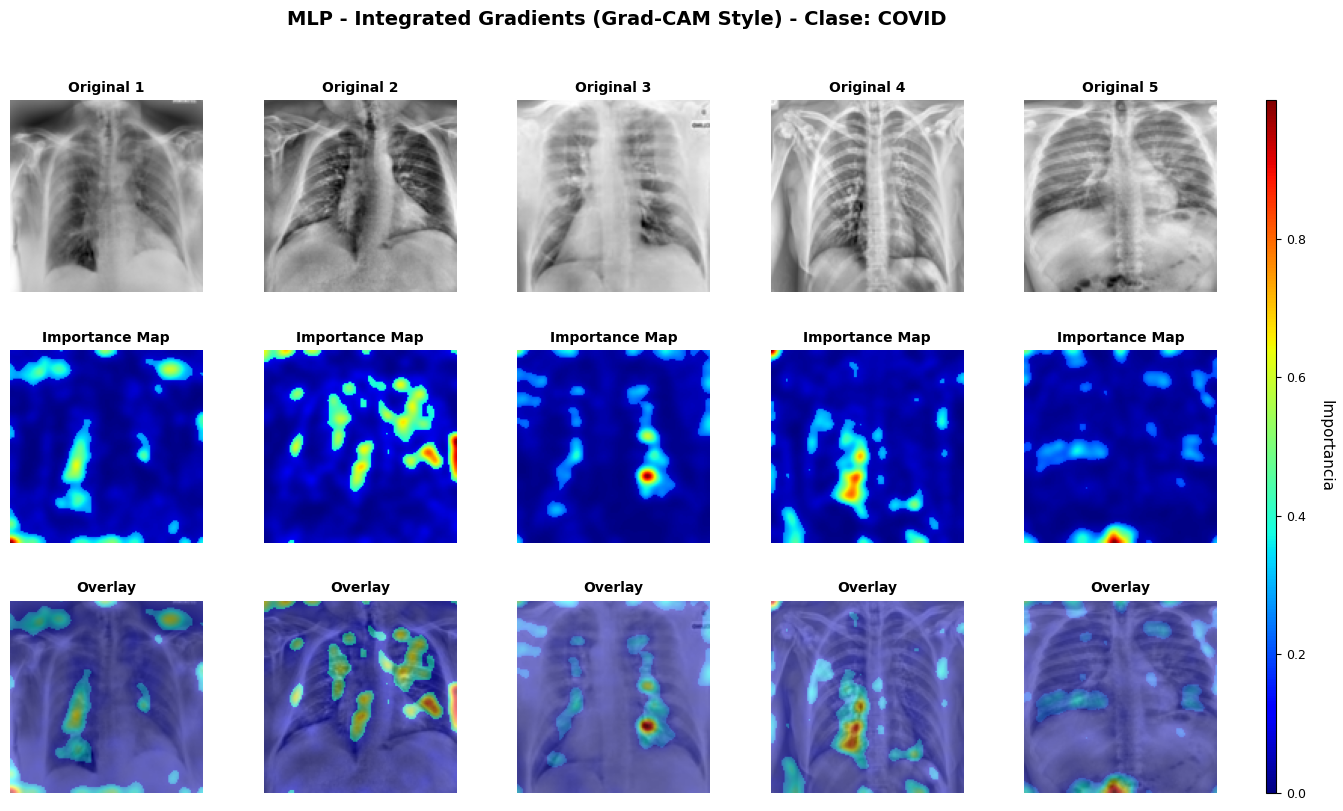


   Procesando clase: Lung_Opacity


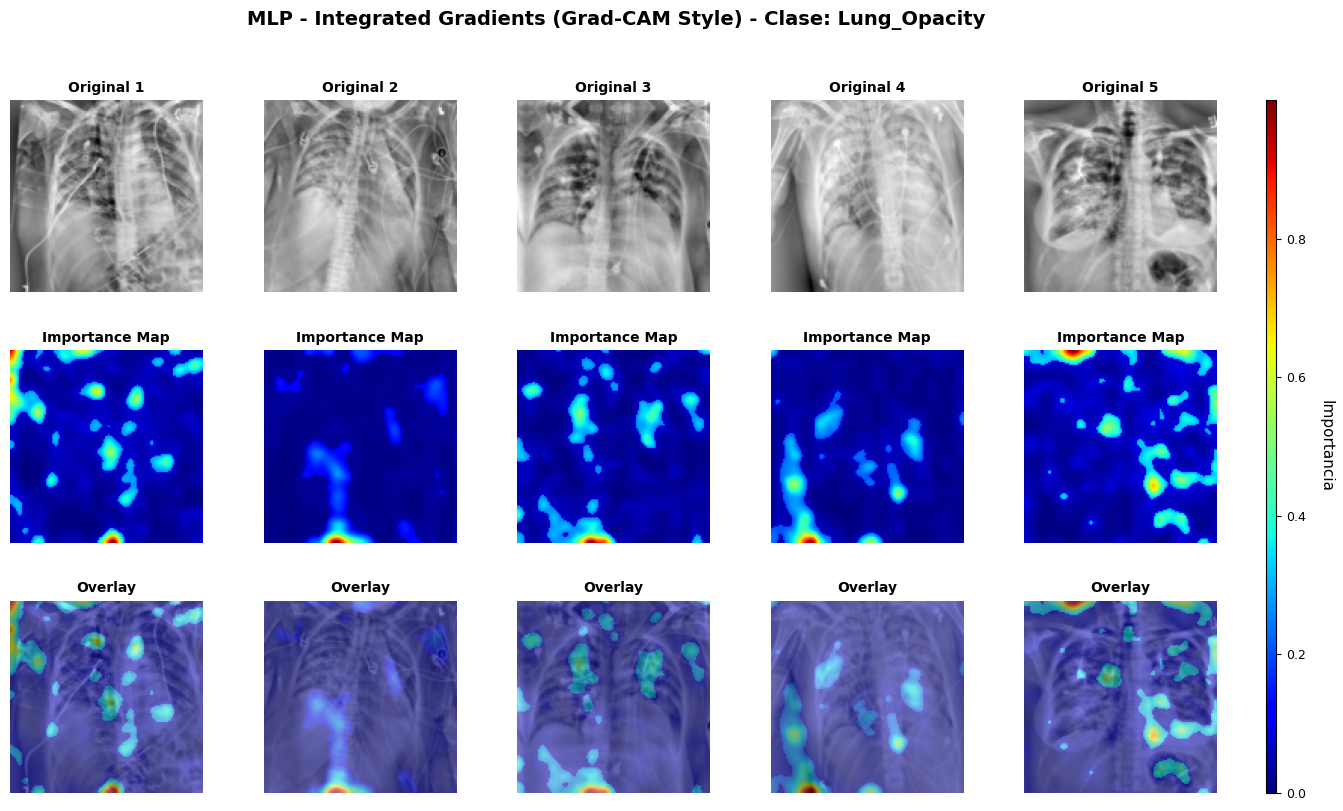


   Procesando clase: Normal


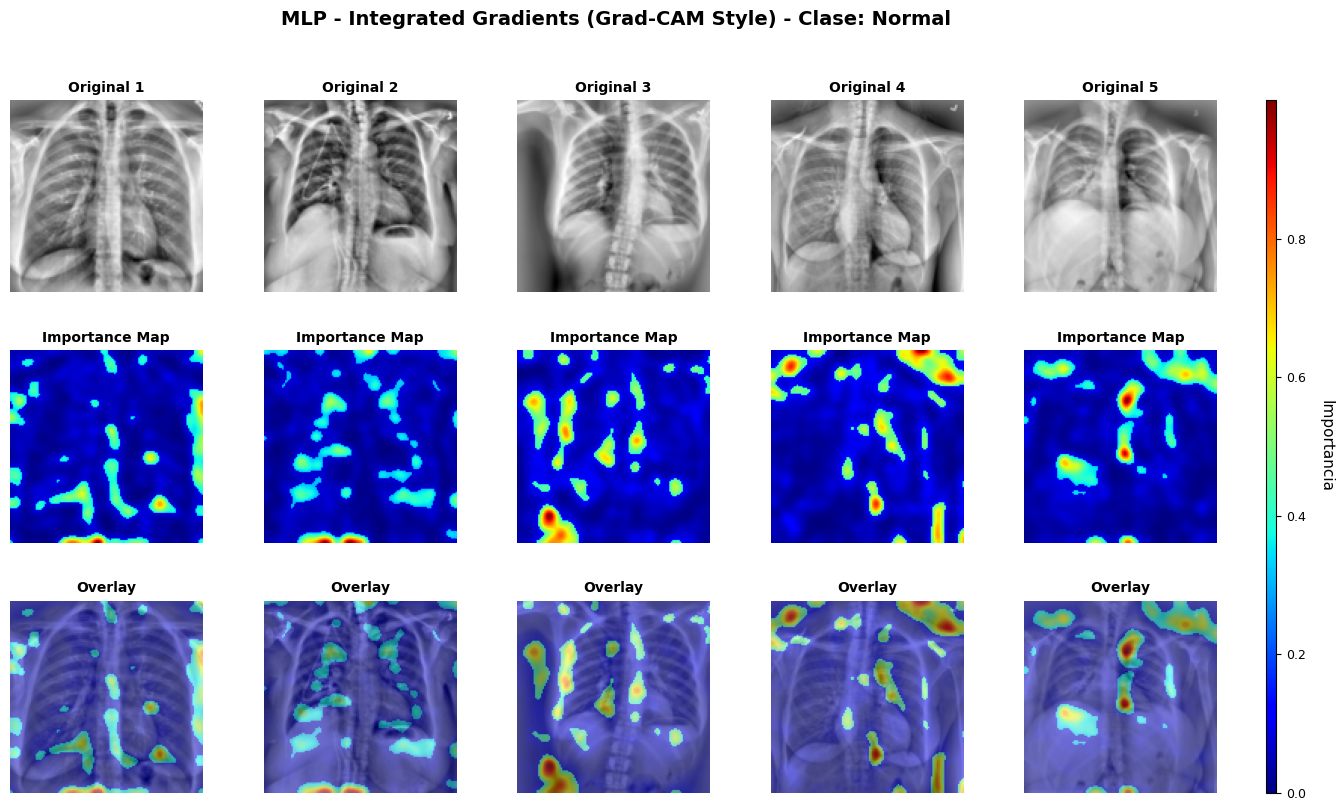


   Procesando clase: Viral Pneumonia


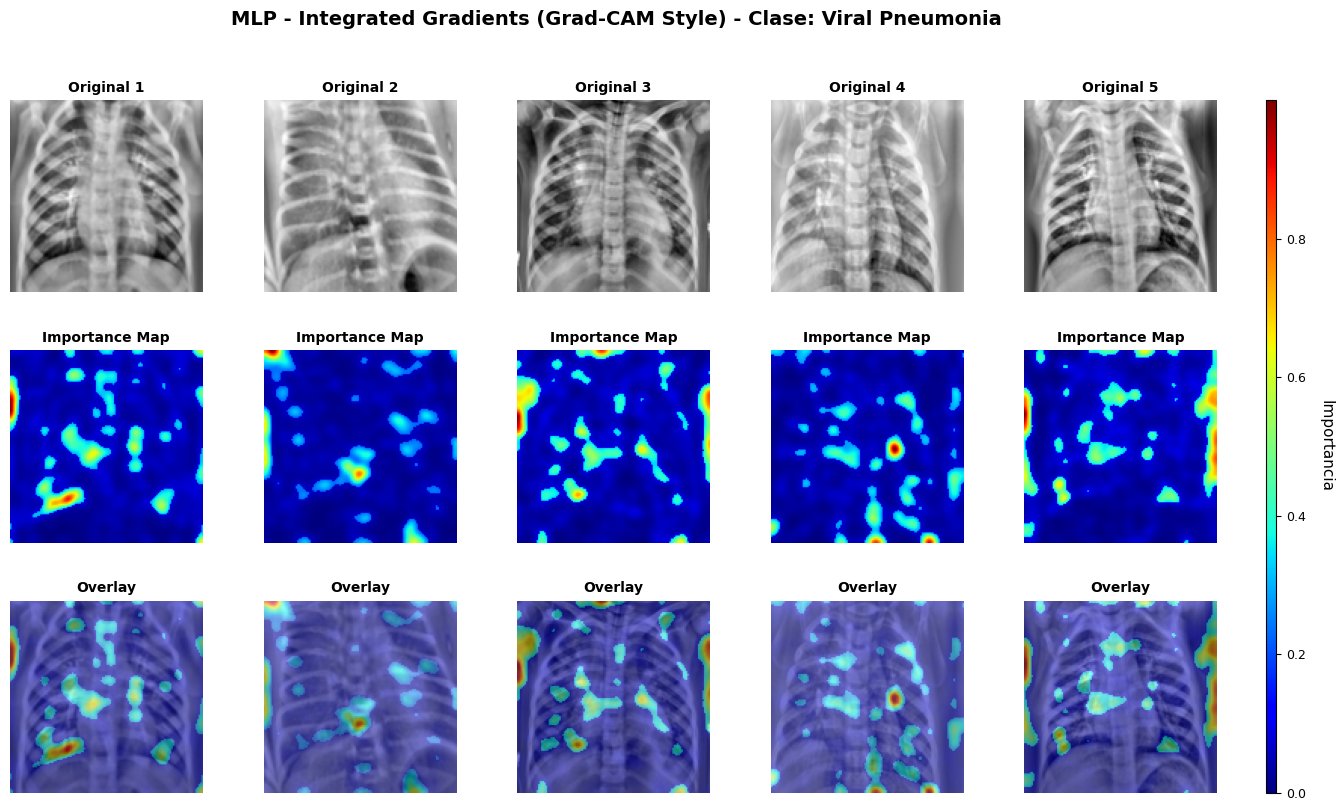

In [ ]:
print("\nCargando modelo entrenado")
model_heatmap, checkpoint = load_trained_mlp_model(heatmap_config['model_path'])

print("\nCargando datos de test")
X_test_heatmap = np.load(f"{heatmap_config['data_prefix']}_X_test.npy")
y_test_heatmap = np.load(f"{heatmap_config['data_prefix']}_y_test.npy")
print(f"   Test set: {X_test_heatmap.shape}")

print("\nGenerando mapas de calor")
visualize_mlp_heatmaps(
    model=model_heatmap,
    X_test=X_test_heatmap,
    y_test=y_test_heatmap,
    class_names=checkpoint['class_names'],
    img_size=heatmap_config['img_size'],
    n_samples=heatmap_config['n_samples'],
    output_dir=heatmap_config['output_dir'],
    use_smoothing=heatmap_config['use_smoothing'],
    sigma=heatmap_config['sigma'],
    percentile=heatmap_config['percentile']
)

# .............................................................................................:::::CNN:::::......................................................................................................................................

## .::Preprocesamiento de dataset original:::......................................................................................................................................

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from collections import Counter

In [ ]:
DATASET_DIR = r"E:\DatasetRecon\COVID-19_Radiography_Dataset\COVID-19_Radiography_Dataset"            # carpeta original con subcarpetas por clase
OUTPUT_DIR = "dataset_preprocessed"  # carpeta destino para los resultados
IMG_SIZE = 224                                # tamaño final (H,W)
RANDOM_STATE = 42
os.makedirs(OUTPUT_DIR, exist_ok=True)
CATEGORIES = sorted([d for d in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, d))])
print("Categorías:", CATEGORIES)

Categorías: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


### Muestra de imagen por categoria


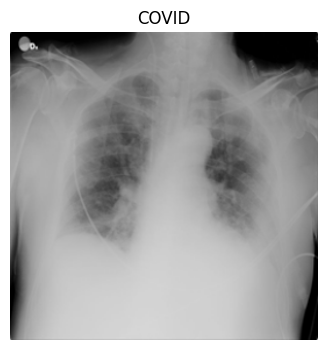

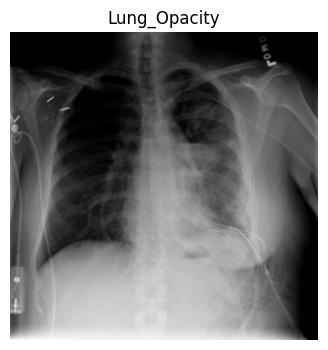

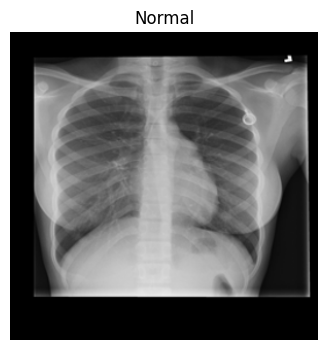

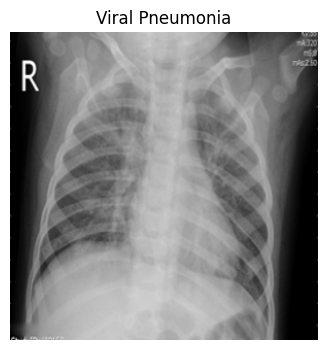

In [ ]:
def show_samples_per_class(dataset_dir, categories, n=1):
    for c in categories:
        folder = os.path.join(dataset_dir, c)
        files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder,f))]
        if not files:
            continue
        for i in range(min(n, len(files))):
            img = cv2.imread(os.path.join(folder, files[i]))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(4,4)); plt.imshow(img); plt.title(c); plt.axis('off'); plt.show()

show_samples_per_class(DATASET_DIR, CATEGORIES, n=1)

In [ ]:
# Funciones para preprocesamiento
def resize_image(img, size=IMG_SIZE):
    return cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)

def crop_remove_borders(img, border_px=20):
    h, w = img.shape[:2]
    return img[border_px:h-border_px, border_px:w-border_px]

def apply_clahe_rgb(img):
    # convertir a LAB y aplicar CLAHE en L
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge((l2, a, b))
    return cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)

def apply_bilateral(img, d=9, sigmaColor=75, sigmaSpace=75):
    return cv2.bilateralFilter(img, d=d, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace)

def normalize_to_uint8(img):
    # img float o uint8 -> aseguramos uint8 en 0..255
    if img.dtype == np.float32 or img.dtype == np.float64:
        img_scaled = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    else:
        img_scaled = img
    return img_scaled



### - Pipeline para procesamiento sin filtro
##### Se remueven 20px a cada borde de la imagen
##### Se hace un rezise de la imagen a 224px
##### Se aplica un filtro CLAHE que aumenta los contrastes de la imagen

In [ ]:
def pipeline_no_filter(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None

    # 1) recorte automático ROI
    #img = crop_by_largest_contour(img)
    # 2) eliminar bordes pequeños
    img = crop_remove_borders(img, border_px=8)
    # 3) aplicar CLAHE
    img = apply_clahe_rgb(img)
    # 4) redimensionar
    img = resize_image(img, IMG_SIZE)
    # 5) normalizar float32 [0,1] para further processing (no guardado)
    img_f = img.astype(np.float32) / 255.0
    return img_f

In [ ]:
# Procesado sin filtro

OUT_RAW = os.path.join(OUTPUT_DIR, "raw_preproc")
os.makedirs(OUT_RAW, exist_ok=True)
for c in CATEGORIES:
    os.makedirs(os.path.join(OUT_RAW, c), exist_ok=True)

# Procesamiento (puede tardar, se hace una sola vez)
for c in CATEGORIES:
    input_folder = os.path.join(DATASET_DIR, c)
    for fname in tqdm(os.listdir(input_folder), desc=f"Procesando {c}"):
        src = os.path.join(input_folder, fname)
        try:
            img_raw = pipeline_no_filter(src)
            if img_raw is None: 
                continue
            # guardar como uint8
            out_path_raw = os.path.join(OUT_RAW, c, fname)
            cv2.imwrite(out_path_raw, cv2.cvtColor(normalize_to_uint8(img_raw), cv2.COLOR_RGB2BGR))
        except Exception as e:
            # log opcional: print("Error en", src, e)
            continue

print("Procesamiento finalizado. Carpetas:", OUT_RAW)

Procesando COVID:   0%|          | 0/3616 [00:00<?, ?it/s]

Procesando Viral Pneumonia: 100%|██████████| 1345/1345 [00:32<00:00, 41.92it/s]

Procesamiento finalizado. Carpetas: dataset_preprocessed\raw_preproc


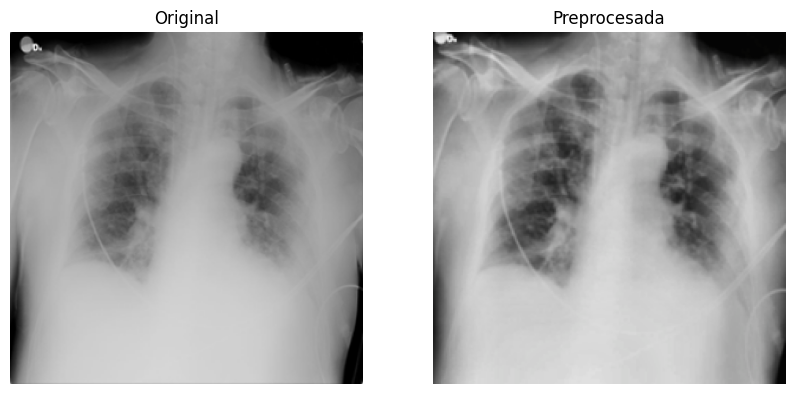

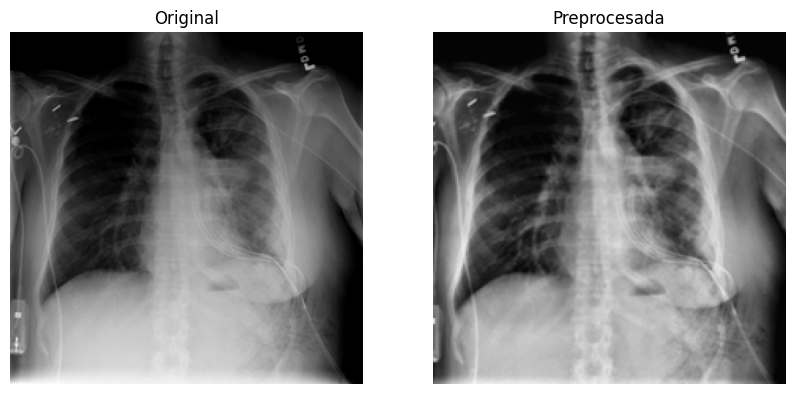

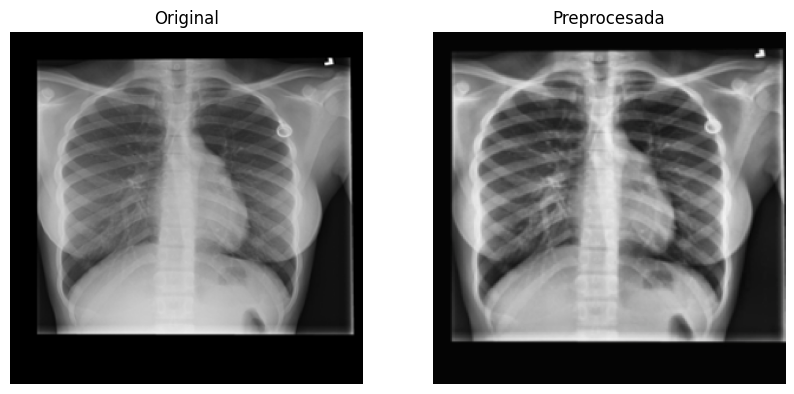

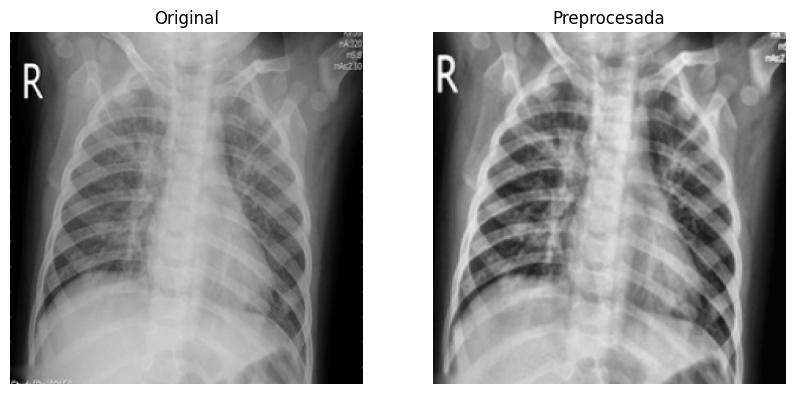

In [ ]:
# Ejemplos de antes y despues de preprocesar
# COVID
img_covid_o = cv2.imread(os.path.join(DATASET_DIR, "COVID/COVID-1.png"))
img_covid_p = cv2.imread(os.path.join(OUT_RAW, "COVID/COVID-1.png"))

img_covid_o = cv2.cvtColor(img_covid_o, cv2.COLOR_BGR2RGB)
img_covid_p = cv2.cvtColor(img_covid_p, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img_covid_o); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_covid_p); plt.title("Preprocesada"); plt.axis('off')
plt.show()

# Lung_Opacity

img_lung_o = cv2.imread(os.path.join(DATASET_DIR, "Lung_Opacity/Lung_Opacity-1.png"))
img_lung_p = cv2.imread(os.path.join(OUT_RAW, "Lung_Opacity/Lung_Opacity-1.png"))

img_lung_o = cv2.cvtColor(img_lung_o, cv2.COLOR_BGR2RGB)
img_lung_p = cv2.cvtColor(img_lung_p, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img_lung_o); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_lung_p); plt.title("Preprocesada"); plt.axis('off')
plt.show()

# Normal

img_normal_o = cv2.imread(os.path.join(DATASET_DIR, "Normal/Normal-1.png"))
img_normal_p = cv2.imread(os.path.join(OUT_RAW, "Normal/Normal-1.png"))

img_normal_o = cv2.cvtColor(img_normal_o, cv2.COLOR_BGR2RGB)
img_normal_p = cv2.cvtColor(img_normal_p, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img_normal_o); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_normal_p); plt.title("Preprocesada"); plt.axis('off')
plt.show()

# Viral Pneumonia

img_viral_o = cv2.imread(os.path.join(DATASET_DIR, "Viral Pneumonia/Viral Pneumonia-1.png"))
img_viral_p = cv2.imread(os.path.join(OUT_RAW, "Viral Pneumonia/Viral Pneumonia-1.png"))

img_viral_o = cv2.cvtColor(img_viral_o, cv2.COLOR_BGR2RGB)
img_viral_p = cv2.cvtColor(img_viral_p, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(img_viral_o); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_viral_p); plt.title("Preprocesada"); plt.axis('off')
plt.show()

### Balanceo de cantidades de imagenes por categoria

In [ ]:
SOURCE_DIR = r"E:\Proyecto2Recon\dataset_preprocessed\raw_preproc"   # dataset ya preprocesado 


TARGET_PER_CLASS = 6000   # cantidad objetivo de imágenes por clase
IMG_SIZE = 224

print("Carpeta fuente:", SOURCE_DIR)


Carpeta fuente: E:\Proyecto2Recon\dataset_preprocessed\raw_preproc


In [ ]:


# Crear imagenes para balanceo

augmentation_transform = transforms.Compose([
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(size=IMG_SIZE, scale=(0.9, 1.05)),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), shear=5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
])

def augment_and_save_image(src_path, dst_folder, n_aug=1):
    """Genera n_aug nuevas versiones de una imagen con pequeñas variaciones."""
    try:
        img = cv2.imread(src_path)
        if img is None:
            return
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        pil = Image.fromarray(img)

        for i in range(n_aug):
            aug_img = augmentation_transform(pil)
            aug_np = cv2.cvtColor(np.array(aug_img), cv2.COLOR_RGB2BGR)
            fname = os.path.splitext(os.path.basename(src_path))[0]
            new_name = f"{fname}_aug{i}.png"
            cv2.imwrite(os.path.join(dst_folder, new_name), aug_np)
    except Exception as e:
        print("Error en augmentación:", src_path, e)


for cat in CATEGORIES:
    src_folder = os.path.join(SOURCE_DIR, cat)
    dst_folder = os.path.join(SOURCE_DIR, cat)

    existing = len(os.listdir(src_folder))
    target = TARGET_PER_CLASS
    deficit = target - existing

    print(f"\nClase: {cat} — {existing} imágenes actuales — objetivo: {target}")

    if deficit > 0:
        print("Generando imagenes...")
        # Cantidad de veces que se deben aumentar las imágenes
        multiplier = max(1, int(np.ceil(deficit / existing)))
        all_files = os.listdir(src_folder)

        generated = 0
        with tqdm(total=deficit, desc=f"Augmentando {cat}") as pbar:
            while generated < deficit:
                for fname in all_files:
                    if generated >= deficit:
                        break
                    augment_and_save_image(os.path.join(src_folder, fname), dst_folder, n_aug=1)
                    generated += 1
                    pbar.update(1)
        existing = len(os.listdir(src_folder))
        deficit = target - existing
        print(f"Clase {cat}: generadas {generated} imágenes nuevas.")
    else:
        print(f"Clase {cat}: ya está balanceada o supera el objetivo.")


Clase: COVID — 6000 imágenes actuales — objetivo: 6000
Clase COVID: ya está balanceada o supera el objetivo.

Clase: Lung_Opacity — 6012 imágenes actuales — objetivo: 6000
Clase Lung_Opacity: ya está balanceada o supera el objetivo.

Clase: Normal — 10192 imágenes actuales — objetivo: 6000
Clase Normal: ya está balanceada o supera el objetivo.

Clase: Viral Pneumonia — 5900 imágenes actuales — objetivo: 6000
Generando imagenes...


Augmentando Viral Pneumonia: 100%|██████████| 100/100 [00:00<00:00, 202.83it/s]

Clase Viral Pneumonia: generadas 100 imágenes nuevas.


In [ ]:
# Conteo final
def count_images(folder):
    counts = {}
    for c in CATEGORIES:
        cpath = os.path.join(folder, c)
        counts[c] = len([f for f in os.listdir(cpath) if os.path.isfile(os.path.join(cpath, f))])
    return counts

current_counts = count_images(SOURCE_DIR)
print("Conteo inicial de imágenes por clase:")
print(current_counts)

final_counts = count_images(SOURCE_DIR)
print("\nConteo final de imágenes por clase (dataset balanceado):")
for k,v in final_counts.items():
    print(f"{k}: {v}")
total_images = sum(final_counts.values())
print(f"\nTotal de imágenes en el dataset balanceado: {total_images}")

Conteo inicial de imágenes por clase:
{'COVID': 6000, 'Lung_Opacity': 6012, 'Normal': 10192, 'Viral Pneumonia': 5900}

Conteo final de imágenes por clase (dataset balanceado):
COVID: 6000
Lung_Opacity: 6012
Normal: 10192
Viral Pneumonia: 5900

Total de imágenes en el dataset balanceado: 28104


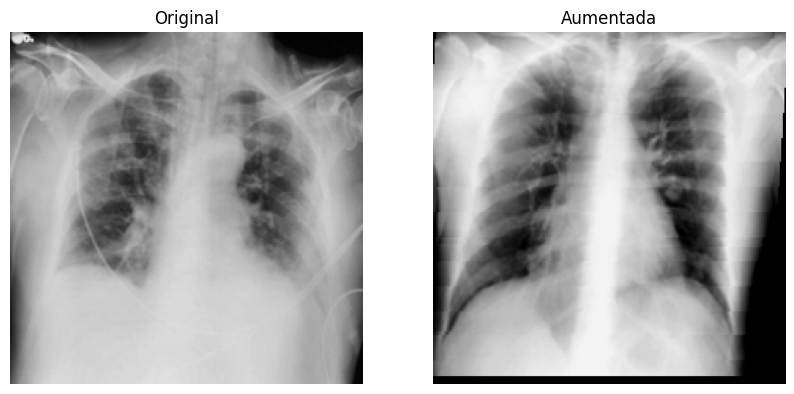

In [ ]:
sample_class = [c for c in CATEGORIES if "aug" not in c][0]
folder = os.path.join(SOURCE_DIR, sample_class)
files = [f for f in os.listdir(folder) if f.endswith(".png")]
originals = [f for f in files if "aug" not in f]
augmented = [f for f in files if "aug" in f]

if originals and augmented:
    img_o = cv2.imread(os.path.join(folder, originals[0]))
    img_a = cv2.imread(os.path.join(folder, augmented[0]))
    img_o = cv2.cvtColor(img_o, cv2.COLOR_BGR2RGB)
    img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.imshow(img_o); plt.title("Original"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(img_a); plt.title("Aumentada"); plt.axis('off')
    plt.show()

else:
    print("No se encontraron imágenes aumentadas para mostrar.")

### Pipeline para aplicar filtro bilateral

In [ ]:
def pipeline_with_bilateral(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print("none")
        return None
    # aplicar bilateral ANTES de resize (más consistente)
    img_f = apply_bilateral(img, d=9, sigmaColor=75, sigmaSpace=75)
    return img_f

In [ ]:
RAW_DIR = os.path.join(OUTPUT_DIR, "raw_preproc")
OUT_FILTERED = os.path.join(OUTPUT_DIR, "filtered_preproc")
os.makedirs(OUT_FILTERED, exist_ok=True)
for c in CATEGORIES:
    os.makedirs(os.path.join(OUT_FILTERED, c), exist_ok=True)

# Procesamiento (puede tardar, se hace una sola vez)
for c in CATEGORIES:
    input_folder = os.path.join(RAW_DIR, c)
    for fname in tqdm(os.listdir(input_folder), desc=f"Procesando {c}"):
        src = os.path.join(input_folder, fname)
        try:
            img_filt = pipeline_with_bilateral(src)
            out_path_filt = os.path.join(OUT_FILTERED, c, fname)
            cv2.imwrite(out_path_filt, cv2.cvtColor(normalize_to_uint8(img_filt), cv2.COLOR_RGB2BGR))
        except Exception as e:
            # log opcional: print("Error en", src, e)
            continue

print("Procesamiento finalizado. Carpetas:", OUT_FILTERED)

Procesando Viral Pneumonia: 100%|██████████| 5900/5900 [00:50<00:00, 116.56it/s]

Procesamiento finalizado. Carpetas: dataset_preprocessed\filtered_preproc
